# Inherint Bias present within different embeddings

## Overview

In this notebook, we will look at several different configurations of datasets, models, and embeddings to determine if any of the embedding/model combinations appear to show more bias than others. We will start by training 3 different model archetectures on 2 different datasets using 2 different embeddings to classify sentences/words as positive or negative (Sentiment analysis). Once we have the models trained, we will look at a curated set of names and throw sentences such as "Hello, my name is (Name)" to see if there is a signifigant difference between the percieved seniment scores of the sentences.

### Datasets that we will use
We will be leveraging two different datasets. The first is one from kaggle that has sentiment scores as either positive or negative that was curated from twitter (this dataset is at the sentence level https://www.kaggle.com/datasets/kazanova/sentiment140/discussion/454347). The second dataset is the one that we utilized in class and is labeled at an individual word level (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). We chose to use two different datasets in order to get a fair comparison between the different embeddings. We will be using a similar technique that we saw in class, taking the sentiment for each word in a sentence and averaging the sentiment score across it, as well as concating the embedding vectors for a sentence together, running PCA on it to reduce down to 300 dimensions and classifying at the sentence level. This was necessary because BERT was designed to take into the entire context of a sentence, not just a single word at a time. We hypothesize that the BERT embeddings will be signifigantly better at the sentence level compared to GLOVE, but we are interested in seeing how BERT will perform in the word level classification with an average sentiment value.

### Models that we will use
We will be leveraging 3 different classifier archetictures to feed the BERT and GLOVE embeddings into for sentiment analysis to see if one of the model archetectures further contrubutes to an inherint bias. The model archetectures that we will use will be as follows:
- A simple deep neural network (1 64 neuron layer, a dropout layer, and a single neuron layer to output the sentiment score)
- A simple LogisticRegression classifier
- A recurrent neural net (TODO: Will/Rick talk more on this archetecture)

### Embeddings that we will use
We will be leveraging both the glove.840B.300d and a BERT embedding. 
#### GLOVE
The glove embedding is just a simple download and lookup table in order to extract the vector for a single word. When we are using GLOVE with a sentence, we took two approaches. Firstly, we took the embedding for each word, classified each word with a sentiment score, and then averaged across the sentence. The second approach of getting a sentiment score for a sentence was to concatinate the vectors of each word in the sentence, and then run a PCA decomposition on those vectors to get back into a 300 dimensional vector. (The vectors that were not the length of the max length were padded with 0 vectors to meet the max length) ie. `[[0.4, 0.3, 0.2, 0.6],[0.1, 0.1]]` -> `[[0.4, 0.3, 0.2],[0.1, 0.1, 0.0, 0.0]]`
#### BERT
The second embedding that we wanted to lookat was a BERT embedding. This was a bit more complicated to obtain than the lookup table of glove. We feed each sentence(or word if we are doing the word based approach) into BERT and steal the last hidden layer for that sentence. Once we have that vector (768 dimensions), we run a PCA decomposition in order to compress it down to 300 dimensions so that we can feed these embeddings into the same classifiers.

__NOTE:__ The PCA decomposition was fit to ONLY the training set and was used to transform the test and validation sets used in training in order to avoid cross contamination between the training testing and validation sets 

## Code

### Data preparation
In this section, we grab the two datasets and label them `sentence_df` and `word_df` for the tweet dataset and the sentiment lexicon from class respectivley. We also create the Generator object that is responsible for getting different embeddings given a dataframe and splitting them into train, test, and validation sets. See `embeddings.py` for the implementation of this class.

In [1]:
from embeddings import EmbeddingGenerator
import helpers
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import SGDClassifier
gen = EmbeddingGenerator(only_bert=False,cached_embedding_path = '../../data/concept_net/cached_embeddings') # Creating a Generator object that handles all of the embedding conversions

sentence_df = helpers.pre_process_input_data(filepath='../../data/concept_net/tweets.csv',num_samples=5000) # Getting the data from the tweet dataset
pos_words = helpers.load_lexicon('../../data/concept_net/positive-words.txt')
neg_words = helpers.load_lexicon('../../data/concept_net/negative-words.txt')
word_df = pd.concat([ #Convert pos and neg words into single dataframe with labels
    pd.DataFrame({'word':pos_words,'target':[1] * len(pos_words)}),
    pd.DataFrame({'word':neg_words,'target':[0] * len(neg_words)})
])

del pos_words #Clear up ram because god knows this project eats a lot of it 
del neg_words

2024-02-07 12:52:47.491744: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 12:52:47.514936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 12:52:47.514956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 12:52:47.514969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 12:52:47.519670: I tensorflow/core/platform/cpu_feature_g

<Axes: >

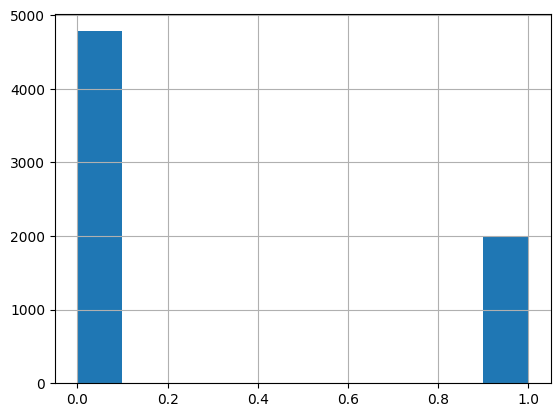

In [2]:
word_df['target'].hist()

<Axes: >

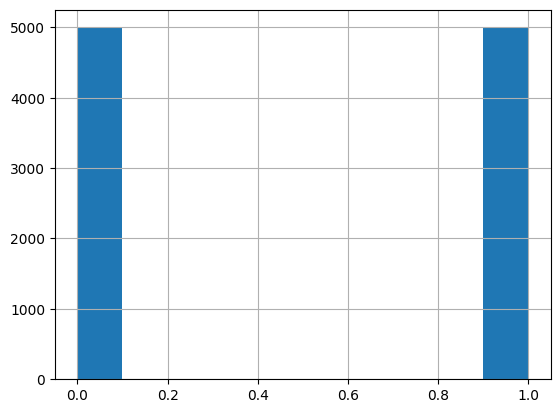

In [3]:
sentence_df['target'].hist()

## Models
bla bla bla talk about model stuff

In [4]:
simple_dense = helpers.generatSimpleDenseNetwork(return_callbacks=False)

In [5]:
plot_model(simple_dense)
del simple_dense

## Sentiment Training

In [6]:
bert_train_features, bert_test_features, bert_val_features,\
    bert_train_labels, bert_test_labels, bert_val_labels, \
    bert_train_text, bert_test_text, bert_val_text = gen.get_train_test_val_with_bert(sentence_df,test_size=0.2)

glove_train_features, glove_test_features, glove_val_features, \
    glove_train_labels, glove_test_labels, glove_val_labels, \
    glove_train_text, glove_test_text, glove_val_text = gen.get_train_test_val_with_other_embedding_multi_word(sentence_df,test_size=0.2)


Grabbing BERT Embeddings with padding to 359 characters


  0%|          | 0/20 [00:00<?, ?it/s]

2024-02-07 12:52:56.897120: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Converting multi word text into Other Embedding (Glove by default)


  0%|          | 0/10000 [00:00<?, ?it/s]

Removing 34 entries that did not exist in embeddings
Max feature vec size: 9600


In [7]:
print(f"""
Bert Train Vector Shape: {bert_train_features.shape}
Bert Validation Vector Shape: {bert_val_features.shape}
Bert Test Vector Shape: {bert_test_features.shape}
"""
     )
print(f"""
Glove Train Vector Shape: {glove_train_features.shape}
Glove Validation Vector Shape: {glove_val_features.shape}
Glove Test Vector Shape: {glove_test_features.shape}
"""
     )


Bert Train Vector Shape: (6400, 300)
Bert Validation Vector Shape: (1600, 300)
Bert Test Vector Shape: (2000, 300)


Glove Train Vector Shape: (6377, 300)
Glove Validation Vector Shape: (1595, 300)
Glove Test Vector Shape: (1994, 300)



### Simple dense network predictor

In [8]:
bert_simple_dense, bert_callbacks = helpers.generatSimpleDenseNetwork()
glove_simple_dense, glove_callbacks = helpers.generatSimpleDenseNetwork()

In [9]:
bert_simple_dense.fit(bert_train_features,bert_train_labels,epochs=200,validation_data=(bert_val_features,bert_val_labels),callbacks=bert_callbacks)
glove_simple_dense.fit(glove_train_features,glove_train_labels,epochs=200,validation_data=(glove_val_features,glove_val_labels),callbacks=glove_callbacks)

Epoch 1/200


2024-02-07 13:06:03.289772: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab7c38c040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 13:06:03.289802: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-07 13:06:03.292733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-07 13:06:03.300761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-07 13:06:03.349056: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 2s 3ms/step - loss: 0.6252 - accuracy: 0.6469 - val_loss: 0.5206 - val_accuracy: 0.7531
Epoch 2/200
200/200 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7505 - val_loss: 0.4758 - val_accuracy: 0.7669
Epoch 3/200
200/200 [==============================] - 0s 2ms/step - loss: 0.4769 - accuracy: 0.7717 - val_loss: 0.4659 - val_accuracy: 0.7694
Epoch 4/200
200/200 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7886 - val_loss: 0.4653 - val_accuracy: 0.7756
Epoch 5/200
200/200 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7956 - val_loss: 0.4635 - val_accuracy: 0.7706
Epoch 6/200
200/200 [==============================] - 0s 2ms/step - loss: 0.4237 - accuracy: 0.8070 - val_loss: 0.4652 - val_accuracy: 0.7669
Epoch 7/200
200/200 [==============================] - 0s 2ms/step - loss: 0.4157 - accuracy: 0.8077 - val_loss: 0.4651 - val_accuracy: 0.7750
Epoch 8/200

In [10]:
bert_simple_dense_df = pd.DataFrame({
    'target':bert_test_labels,
    'text': bert_test_text,
    'predict': bert_simple_dense.predict(bert_test_features).flatten()
})

glove_simple_dense_df = pd.DataFrame({
    'target':glove_test_labels,
    'text': glove_test_text,
    'predict': glove_simple_dense.predict(glove_test_features).flatten()
})

bert_simple_dense_df['diff'] = bert_simple_dense_df['target'] - bert_simple_dense_df['predict']
glove_simple_dense_df['diff'] = glove_simple_dense_df['target'] - glove_simple_dense_df['predict']
# bert_simple_dense.predict(bert_test_features)

63/63 [==============================] - 0s 875us/step


#### Analysis of simple dense net prediction accuracy
We would expect that these graphs are centered around 0 as this would mean that the model was correctly classifying the sentences as either positive or negative. 

__TODO: add actual analysis once the full dataset is sent through this__

<Axes: >

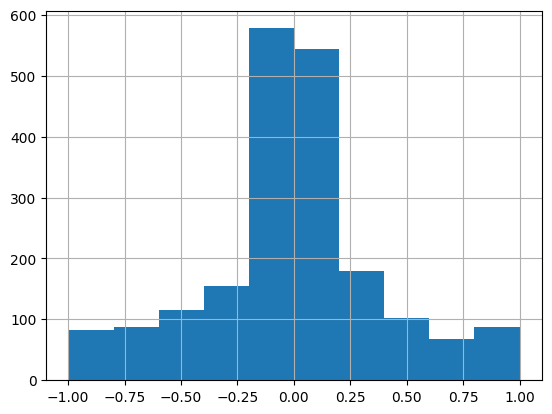

In [11]:
bert_simple_dense_df['diff'].hist(bins=10)

<Axes: >

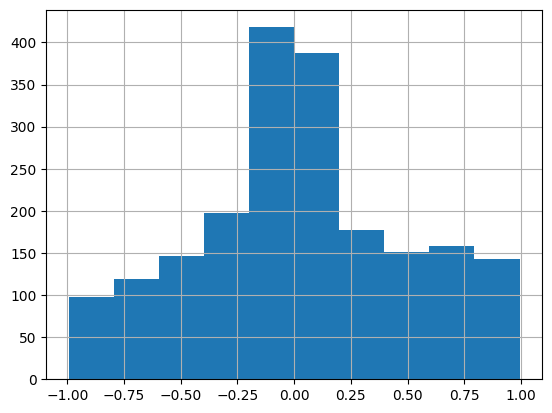

In [12]:
glove_simple_dense_df['diff'].hist(bins=10)

In [13]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 
        'Lavon', 'Marcellus', 'Wardell', 'Nichelle',
        'Ebony', 'Shaniqua', 
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel', 
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

result_df = pd.DataFrame()

for race,names in NAMES_BY_ETHNICITY.items():
    for name in names:
        result_df = pd.concat([result_df, pd.DataFrame({'group':[race],'text':[f'hello my name is {name}']})])

result_df['bert_embedding'] = gen.convert_df_to_bert_embedding(result_df)['features'] 
result_df['glove_embedding'] = gen.convert_df_multi_word_to_other_embedding(result_df)['features']

result_df['bert_embedding'] = gen.dempose_using_bert_pca(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_embedding'] = gen.decompose_using_other_pca(np.array([v for v in result_df['glove_embedding']]))


Grabbing BERT Embeddings with padding to 26 characters


  0%|          | 0/1 [00:00<?, ?it/s]

Converting multi word text into Other Embedding (Glove by default)


  0%|          | 0/128 [00:00<?, ?it/s]

Removing 0 entries that did not exist in embeddings
(128, 9600)


In [14]:
result_df['bert_prediction'] = bert_simple_dense.predict(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_prediction'] = bert_simple_dense.predict(np.array([v for v in result_df['glove_embedding']]))


4/4 [==============================] - 0s 1ms/step


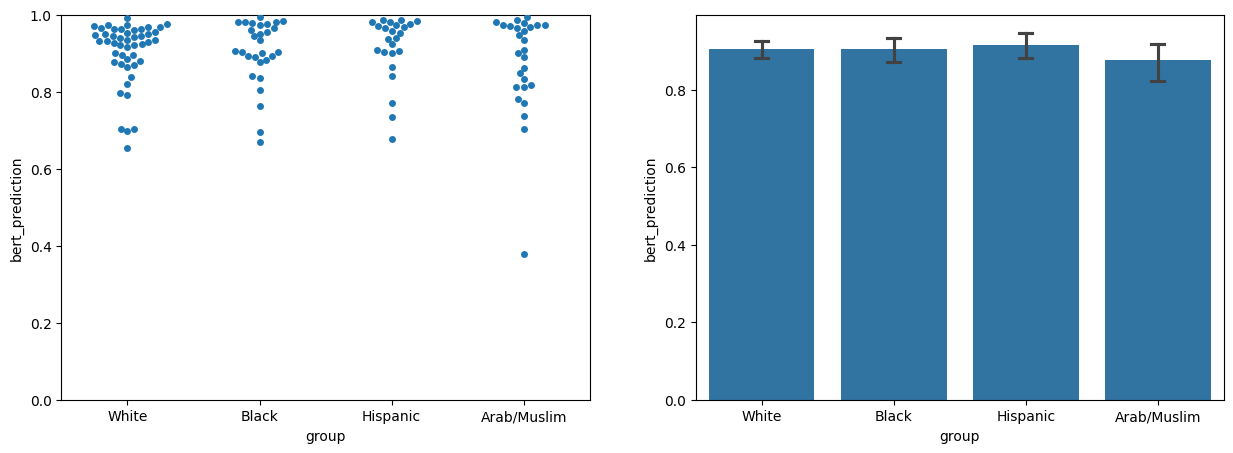

In [15]:

def result_plotter(data,x,y,y_lim=[0,1]):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot = seaborn.swarmplot(x=x, y=y, data=data)
    plot.set_ylim(y_lim)
    plt.subplot(122)
    plot = seaborn.barplot(x=x, y=y, data=data, capsize=.1)

result_plotter(result_df,'group','bert_prediction')

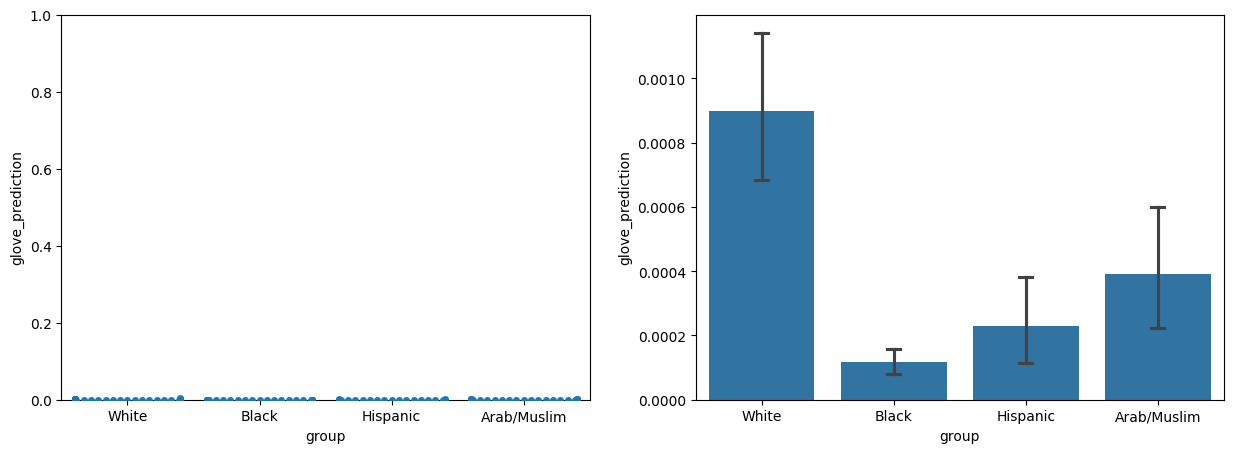

In [16]:
result_plotter(result_df,'group','glove_prediction')

### Logistic Regression classifier

In [17]:

bert_logistic = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)
glove_logistic = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)

bert_logistic.fit(bert_train_features, bert_train_labels)
glove_logistic.fit(glove_train_features, glove_train_labels)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

In [18]:
result_df['bert_prediction'] = bert_logistic.predict(np.array([v for v in result_df['bert_embedding']]))
result_df['glove_prediction'] = glove_logistic.predict(np.array([v for v in result_df['glove_embedding']]))

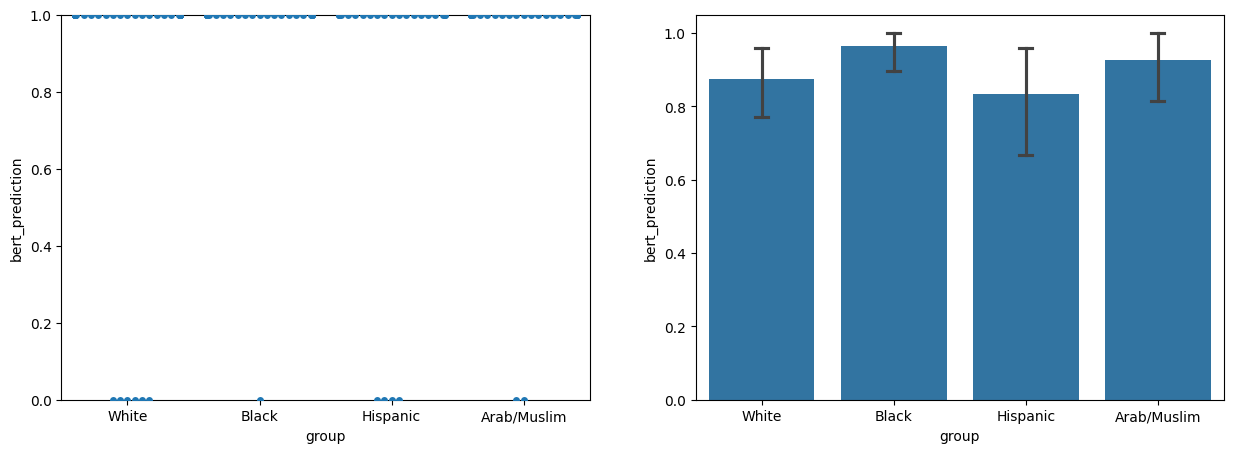

In [19]:
result_plotter(result_df,'group','bert_prediction',y_lim=[0,1])


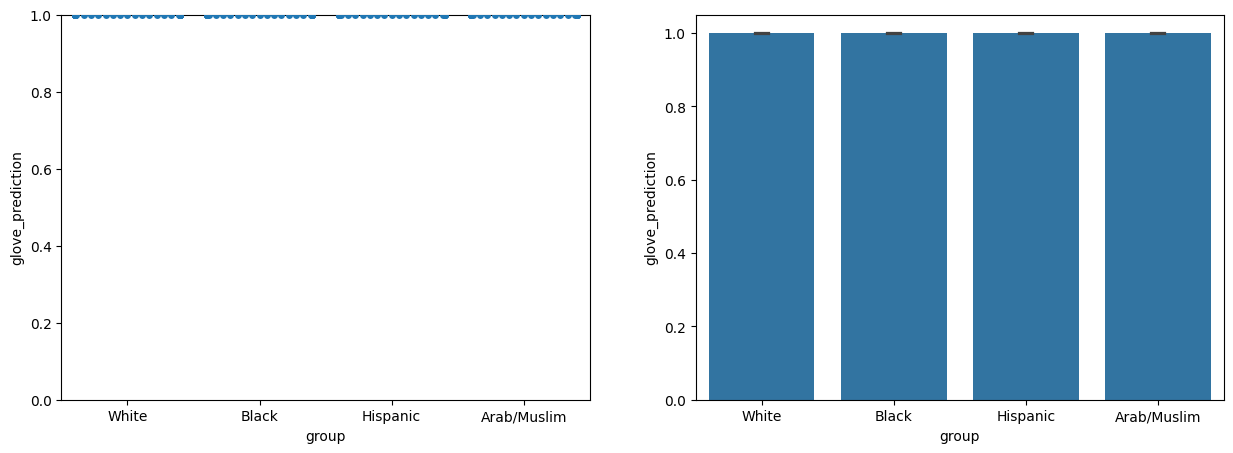

In [20]:
result_plotter(result_df,'group','glove_prediction')